In [13]:
import pandas as pd
import numpy as np
import spacy
import utility.text_normalizer as tn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns
import joblib
import tqdm
from xgboost import XGBClassifier

# Define metric functions

In [2]:
def print_scores(model, y_true, X_val):
    y_pred = model.predict(X_val)
    print(classification_report(y_true, y_pred, target_names=['irrelevant', 'relevant']))
    sns.heatmap(confusion_matrix(y_true, y_pred).T, square=True, annot=True, fmt='d')

# Load the word embeddings

In [3]:
X_train = np.load('data/X_train_wb.npy')
y_train = np.load('data/y_train.npy')
X_test = np.load('data/X_test_wb.npy')
y_test = np.load('data/y_test.npy')

## Current best model if RF

In [5]:
rf = joblib.load('../../../models/rf_83.pkl')

/Users/Isaacbolo/opt/anaconda3/envs/CDFW/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/Isaacbolo/opt/anaconda3/envs/CDFW/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


              precision    recall  f1-score   support

  irrelevant       0.96      0.86      0.91       452
    relevant       0.76      0.92      0.83       208

    accuracy                           0.88       660
   macro avg       0.86      0.89      0.87       660
weighted avg       0.90      0.88      0.88       660



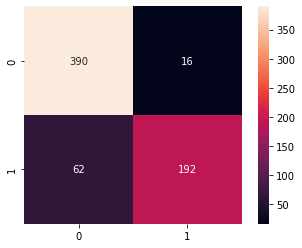

In [6]:
print_scores(rf, y_test, X_test)

This is the score to beat, Im focusing more on macro avg F1 and relevant f1

# Baseline xgboost

In [8]:
baseline_xgc = XGBClassifier(n_jobs=-1, learning_rate=0.1, max_depth=4)
baseline_xgc.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_delta_step': None,
 'max_depth': 4,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'verbose': 1}

In [9]:
baseline_xgc.fit(X_train, y_train)

/Users/Isaacbolo/opt/anaconda3/envs/CDFW/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:12:48] WARNING: ../src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:12:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbose=1,
              verbosity=None)

              precision    recall  f1-score   support

  irrelevant       0.91      0.90      0.90       452
    relevant       0.78      0.81      0.80       208

    accuracy                           0.87       660
   macro avg       0.85      0.85      0.85       660
weighted avg       0.87      0.87      0.87       660



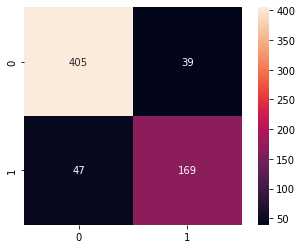

In [11]:
print_scores(baseline_xgc, y_test, X_test)

In [18]:
xgc = XGBClassifier(n_jobs=-1)
grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0, 0.1, 0.5, 1],
    'n_estimators': [100, 150, 200],
}
grid_search = GridSearchCV(xgc, param_grid=grid, n_jobs=-1, scoring='f1', verbose=1, cv=2)

In [19]:
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 36 candidates, totalling 72 fits


/Users/Isaacbolo/opt/anaconda3/envs/CDFW/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:57:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=N

In [22]:
xgc1 = grid_search.best_estimator_
xgc1, grid_search.best_score_

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
               gamma=0, gpu_id=-1, importance_type=None,
               interaction_constraints='', learning_rate=0.1, max_delta_step=0,
               max_depth=5, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=200, n_jobs=-1,
               num_parallel_tree=1, predictor='auto', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None),
 0.7476258053966414)

              precision    recall  f1-score   support

  irrelevant       0.94      0.90      0.92       452
    relevant       0.80      0.88      0.84       208

    accuracy                           0.89       660
   macro avg       0.87      0.89      0.88       660
weighted avg       0.90      0.89      0.89       660



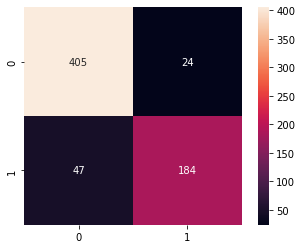

In [24]:
# See how it performs against the test set
print_scores(xgc1, y_test, X_test)

              precision    recall  f1-score   support

  irrelevant       0.96      0.96      0.96     29860
    relevant       0.92      0.91      0.92     14184

    accuracy                           0.95     44044
   macro avg       0.94      0.94      0.94     44044
weighted avg       0.95      0.95      0.95     44044



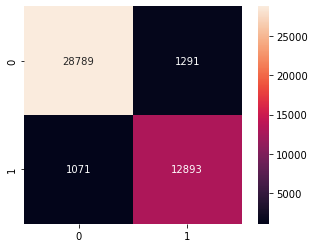

In [25]:
# See how it does on training set
print_scores(xgc1, y_train, X_train)

Do another search to fine tune the hyperparams

In [26]:
xgc = XGBClassifier(n_jobs=-1)
grid = {
    'max_depth': [5, 6],
    'learning_rate': [0.075, 0.1, 0.25],
    'n_estimators': [200, 300],
}
grid_search2 = GridSearchCV(xgc, param_grid=grid, scoring='f1', cv=2, n_jobs=-1, verbose=3)

In [27]:
grid_search2.fit(X_train, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


/Users/Isaacbolo/opt/anaconda3/envs/CDFW/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:34:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END learning_rate=0.075, max_depth=5, n_estimators=200;, score=0.651 total time= 6.5min
[15:11:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END learning_rate=0.1, max_depth=5, n_estimators=200;, score=0.845 total time= 6.9min
[15:17:57] WARNING: ../src/learner.cc:1115: Starting

/Users/Isaacbolo/opt/anaconda3/envs/CDFW/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Isaacbolo/opt/anaconda3/envs/CDFW/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/Isaacbolo/opt/anaconda3/envs/CDFW/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do t

[15:04:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END learning_rate=0.075, max_depth=6, n_estimators=300;, score=0.653 total time=13.2min
[15:17:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END learning_rate=0.1, max_depth=6, n_estimators=300;, score=0.851 total time=14.4min


/Users/Isaacbolo/opt/anaconda3/envs/CDFW/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Isaacbolo/opt/anaconda3/envs/CDFW/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/Isaacbolo/opt/anaconda3/envs/CDFW/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do t

[15:04:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END learning_rate=0.075, max_depth=6, n_estimators=200;, score=0.649 total time= 9.0min
[15:13:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.848 total time=10.5min
[15:23:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END learning_rate=0.25, max_depth=6, n_esti

/Users/Isaacbolo/opt/anaconda3/envs/CDFW/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Isaacbolo/opt/anaconda3/envs/CDFW/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/Isaacbolo/opt/anaconda3/envs/CDFW/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do t

[15:04:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END learning_rate=0.075, max_depth=5, n_estimators=300;, score=0.653 total time= 9.8min
[15:14:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END learning_rate=0.1, max_depth=6, n_estimators=200;, score=0.846 total time= 9.4min
[15:23:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END learning_rate=0.25, max_depth=6, n_esti

/Users/Isaacbolo/opt/anaconda3/envs/CDFW/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Isaacbolo/opt/anaconda3/envs/CDFW/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/Isaacbolo/opt/anaconda3/envs/CDFW/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do t

[15:04:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/2] END learning_rate=0.075, max_depth=6, n_estimators=200;, score=0.847 total time= 9.1min
[15:13:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END learning_rate=0.1, max_depth=5, n_estimators=300;, score=0.655 total time=10.1min
[15:23:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/2] END learning_rate=0.25, max_depth=5, n_esti

/Users/Isaacbolo/opt/anaconda3/envs/CDFW/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/Isaacbolo/opt/anaconda3/envs/CDFW/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/Isaacbolo/opt/anaconda3/envs/CDFW/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do t

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=N

In [28]:
grid_search2.best_params_

{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}

In [29]:
xgc2 = grid_search2.best_estimator_

              precision    recall  f1-score   support

  irrelevant       0.95      0.88      0.91       452
    relevant       0.77      0.90      0.83       208

    accuracy                           0.88       660
   macro avg       0.86      0.89      0.87       660
weighted avg       0.89      0.88      0.89       660



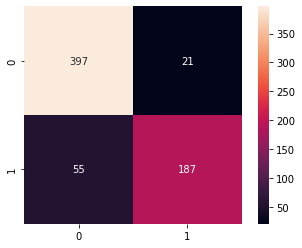

In [30]:
print_scores(xgc2, y_test, X_test)

In [31]:
xgc2.set_params(n_estimators=400)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [32]:
xgc2.fit(X_train, y_train)

/Users/Isaacbolo/opt/anaconda3/envs/CDFW/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:42:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

              precision    recall  f1-score   support

  irrelevant       0.95      0.87      0.91       452
    relevant       0.77      0.89      0.82       208

    accuracy                           0.88       660
   macro avg       0.86      0.88      0.87       660
weighted avg       0.89      0.88      0.88       660



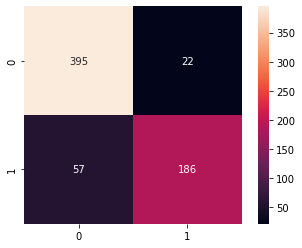

In [33]:
print_scores(xgc2, y_test, X_test)

              precision    recall  f1-score   support

  irrelevant       0.94      0.90      0.92       452
    relevant       0.80      0.88      0.84       208

    accuracy                           0.89       660
   macro avg       0.87      0.89      0.88       660
weighted avg       0.90      0.89      0.89       660



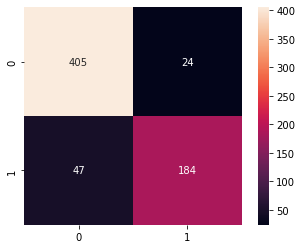

In [35]:
print_scores(xgc1, y_test, X_test)

In [36]:
# Save the best model
# joblib.dump(xgc1, '../../../models/xgc_.89.pkl')

['../../../models/xgc_.89.pkl']